In [2]:
!pip install pandas
!pip install hazm
!pip install nltk
!pip install tqdm

In [3]:
import pandas as pd
from hazm import *
import tqdm
import json
import codecs
import numpy as np
import random
import csv
import pickle
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [4]:
news_dict = {}
with open('../data/news.json', "r", encoding="utf-8") as text_file:
        news_dict = json.loads(text_file.read())

df = pd.DataFrame.from_dict(news_dict, orient='index')
df

,title,subject,content
0,هاشمی: هماهنگ کردم آزمون خبرگان را از حسن روحا...,سیاسی,به گزارش همشهری آنلاین، روزنامه فرهیختگان در ش...
1,اصلاح قانون اسلحه از کجا کلید خورد؟ ا مامور ...,سیاسی,همشهری‌آنلاین- امیرمحمدحسینی:اصلاحیه قانون به ...
2,ایران در برابر قطعنامه‌های آژانس سکوت نمی‌کند ...,سیاسی,به گزارش همشهری‌آنلاین،فدا حسین مالکی در مورد ...
3,اینفوگرافیک | اصلاحات قانون به‌کارگیری اسلحه چ...,سیاسی,ЩҮЩ…ШҙЩҮШұЫҢ ШўЩҶЩ„Ш§ЫҢЩҶ - Ш§Щ…ЫҢШұЩ…ШӯЩ…ШҜ Ш...
4,پیام تبریک رئیسی به رییس‌جمهور فیلیپین,سیاسی,به گزارش همشهری‌آنلاین، آیت‌الله سید ابراهیم ر...
...,...,...,...
14871,عکس | ۲ ستاره تیم ملی در میان برترین گلزنان مق...,ورزش,به گزارش همشهری آنلاین مسابقات مقدماتی جام جها...
14872,عکس| ۲۷ تیم راه یافته به جام جهانی | ۵ تیم باق...,ورزش,به گزارش همشهری آنلاین با صعود پرتغال و لهستان...
14873,عکس | برد پرگل برزیل در شب خداحافظی کلمبیا و ش...,ورزش,به گزارش همشهری آنلاین مسابقات مقدماتی جام جها...
14874,خداحافظی غم انگیز کی روش با تیم ملی مصر | رنج ...,ورزش,به گزارش همشهری آنلاین تیم ملی مصر در مصاف با ...


In [5]:
normalizer = Normalizer()

normalized_news_dict = {}
for idx,value in tqdm.tqdm(news_dict.items()):
    normalized_news_dict[idx] = {"title" : value['title'] ,"subject" : value["subject"], "content":normalizer.normalize(value['content'])}
  
news_df = pd.DataFrame.from_dict(normalized_news_dict, orient='index')

100%|████████████████████████████████████| 14876/14876 [00:15<00:00, 989.46it/s]


In [6]:
new_stopwords = [normalizer.normalize(x.strip()) for x in codecs.open('../custom_requirments/new_stopwords.txt','r','utf-8').readlines()]
stopwords = [normalizer.normalize(x.strip()) for x in codecs.open('../custom_requirments/stopwords.txt','r','utf-8').readlines()]

In [7]:
tokenized_words = [word_tokenize(_) for _ in news_df.content]

In [8]:
removed_tokenized_words = []
for per_content_words in tokenized_words:
  words = []
  for word in per_content_words:
    if word not in stopwords + new_stopwords:
      words.append(word)
  removed_tokenized_words.append(words)

news_df['word_tokenize'] = removed_tokenized_words
news_df

,title,subject,content,word_tokenize
0,هاشمی: هماهنگ کردم آزمون خبرگان را از حسن روحا...,سیاسی,به گزارش همشهری آنلاین، روزنامه فرهیختگان در ش...,"[گزارش, همشهری, آنلاین, روزنامه, فرهیختگان, شم..."
1,اصلاح قانون اسلحه از کجا کلید خورد؟ ا مامور ...,سیاسی,همشهری‌آنلاین- امیرمحمدحسینی: اصلاحیه قانون به...,"[همشهری‌آنلاین-, امیرمحمدحسینی, اصلاحیه, قانون..."
2,ایران در برابر قطعنامه‌های آژانس سکوت نمی‌کند ...,سیاسی,به گزارش همشهری‌آنلاین، فدا حسین مالکی در مورد...,"[گزارش, همشهری‌آنلاین, فدا, حسین, مالکی, قطعنا..."
3,اینفوگرافیک | اصلاحات قانون به‌کارگیری اسلحه چ...,سیاسی,ЩҮЩ…ШҙЩҮШұЫҢ ШўЩҶЩ„Ш§ЫҢЩҶ - Ш§Щ…ЫҢШұЩ…ШӯЩ…ШҜ Ш...,"[ЩҮЩ…ШҙЩҮШұЫҢ, ШўЩҶЩ„Ш§ЫҢЩҶ, Ш§Щ…ЫҢШұЩ…ШӯЩ…ШҜ,..."
4,پیام تبریک رئیسی به رییس‌جمهور فیلیپین,سیاسی,به گزارش همشهری‌آنلاین، آیت‌الله سید ابراهیم ر...,"[گزارش, همشهری‌آنلاین, آیت‌الله, سید, ابراهیم,..."
...,...,...,...,...
14871,عکس | ۲ ستاره تیم ملی در میان برترین گلزنان مق...,ورزش,به گزارش همشهری آنلاین مسابقات مقدماتی جام جها...,"[گزارش, همشهری, آنلاین, مسابقات, مقدماتی, جام,..."
14872,عکس| ۲۷ تیم راه یافته به جام جهانی | ۵ تیم باق...,ورزش,به گزارش همشهری آنلاین با صعود پرتغال و لهستان...,"[گزارش, همشهری, آنلاین, صعود, پرتغال, لهستان, ..."
14873,عکس | برد پرگل برزیل در شب خداحافظی کلمبیا و ش...,ورزش,به گزارش همشهری آنلاین مسابقات مقدماتی جام جها...,"[گزارش, همشهری, آنلاین, مسابقات, مقدماتی, جام,..."
14874,خداحافظی غم انگیز کی روش با تیم ملی مصر | رنج ...,ورزش,به گزارش همشهری آنلاین تیم ملی مصر در مصاف با ...,"[گزارش, همشهری, آنلاین, تیم, ملی, مصر, مصاف, س..."


In [9]:
stemmer = Stemmer()
lemmatizer = Lemmatizer()

def get_lemma_set(tok, opt=1):
    if opt == 1:
        return stemmer.stem(tok)
    if opt == 2:
        return lemmatizer.lemmatize(tok)

In [10]:
opt = 2
lemmatize_stemming_words = []
for per_content_words in news_df.word_tokenize:
  words = []
  for word in per_content_words:
    words.append(get_lemma_set(word,opt))
  lemmatize_stemming_words.append(words)
news_df['word_lemmatize'] = lemmatize_stemming_words
news_df

,title,subject,content,word_tokenize,word_lemmatize
0,هاشمی: هماهنگ کردم آزمون خبرگان را از حسن روحا...,سیاسی,به گزارش همشهری آنلاین، روزنامه فرهیختگان در ش...,"[گزارش, همشهری, آنلاین, روزنامه, فرهیختگان, شم...","[گزارش, همشهری, آنلاین, روزنامه, فرهیختگان, شم..."
1,اصلاح قانون اسلحه از کجا کلید خورد؟ ا مامور ...,سیاسی,همشهری‌آنلاین- امیرمحمدحسینی: اصلاحیه قانون به...,"[همشهری‌آنلاین-, امیرمحمدحسینی, اصلاحیه, قانون...","[همشهری‌آنلاین-, امیرمحمدحسینی, اصلاحیه, قانون..."
2,ایران در برابر قطعنامه‌های آژانس سکوت نمی‌کند ...,سیاسی,به گزارش همشهری‌آنلاین، فدا حسین مالکی در مورد...,"[گزارش, همشهری‌آنلاین, فدا, حسین, مالکی, قطعنا...","[گزارش, همشهری‌آنلاین, فدا, حسین, مالکی, قطعنا..."
3,اینفوگرافیک | اصلاحات قانون به‌کارگیری اسلحه چ...,سیاسی,ЩҮЩ…ШҙЩҮШұЫҢ ШўЩҶЩ„Ш§ЫҢЩҶ - Ш§Щ…ЫҢШұЩ…ШӯЩ…ШҜ Ш...,"[ЩҮЩ…ШҙЩҮШұЫҢ, ШўЩҶЩ„Ш§ЫҢЩҶ, Ш§Щ…ЫҢШұЩ…ШӯЩ…ШҜ,...","[ЩҮЩ…ШҙЩҮШұЫҢ, ШўЩҶЩ„Ш§ЫҢЩҶ, Ш§Щ…ЫҢШұЩ…ШӯЩ…ШҜ,..."
4,پیام تبریک رئیسی به رییس‌جمهور فیلیپین,سیاسی,به گزارش همشهری‌آنلاین، آیت‌الله سید ابراهیم ر...,"[گزارش, همشهری‌آنلاین, آیت‌الله, سید, ابراهیم,...","[گزارش, همشهری‌آنلاین, آیت‌الله, سید, ابراهیم,..."
...,...,...,...,...,...
14871,عکس | ۲ ستاره تیم ملی در میان برترین گلزنان مق...,ورزش,به گزارش همشهری آنلاین مسابقات مقدماتی جام جها...,"[گزارش, همشهری, آنلاین, مسابقات, مقدماتی, جام,...","[گزارش, همشهری, آنلاین, مسابقات, مقدمات, جام, ..."
14872,عکس| ۲۷ تیم راه یافته به جام جهانی | ۵ تیم باق...,ورزش,به گزارش همشهری آنلاین با صعود پرتغال و لهستان...,"[گزارش, همشهری, آنلاین, صعود, پرتغال, لهستان, ...","[گزارش, همشهری, آنلاین, صعود, پرتغال, لهستان, ..."
14873,عکس | برد پرگل برزیل در شب خداحافظی کلمبیا و ش...,ورزش,به گزارش همشهری آنلاین مسابقات مقدماتی جام جها...,"[گزارش, همشهری, آنلاین, مسابقات, مقدماتی, جام,...","[گزارش, همشهری, آنلاین, مسابقات, مقدمات, جام, ..."
14874,خداحافظی غم انگیز کی روش با تیم ملی مصر | رنج ...,ورزش,به گزارش همشهری آنلاین تیم ملی مصر در مصاف با ...,"[گزارش, همشهری, آنلاین, تیم, ملی, مصر, مصاف, س...","[گزارش, همشهری, آنلاین, تیم, ملی, مصر, مصاف, س..."


In [11]:
words = []
for row_words in news_df['word_lemmatize']:
  words.append(' '.join(row_words))
news_df['clean_text'] = words
news_df = news_df.drop(['word_tokenize','word_lemmatize'],axis=1)
news_df

,title,subject,content,clean_text
0,هاشمی: هماهنگ کردم آزمون خبرگان را از حسن روحا...,سیاسی,به گزارش همشهری آنلاین، روزنامه فرهیختگان در ش...,گزارش همشهری آنلاین روزنامه فرهیختگان شماره ام...
1,اصلاح قانون اسلحه از کجا کلید خورد؟ ا مامور ...,سیاسی,همشهری‌آنلاین- امیرمحمدحسینی: اصلاحیه قانون به...,همشهری‌آنلاین- امیرمحمدحسینی اصلاحیه قانون کار...
2,ایران در برابر قطعنامه‌های آژانس سکوت نمی‌کند ...,سیاسی,به گزارش همشهری‌آنلاین، فدا حسین مالکی در مورد...,گزارش همشهری‌آنلاین فدا حسین مالکی قطعنامه ضد ...
3,اینفوگرافیک | اصلاحات قانون به‌کارگیری اسلحه چ...,سیاسی,ЩҮЩ…ШҙЩҮШұЫҢ ШўЩҶЩ„Ш§ЫҢЩҶ - Ш§Щ…ЫҢШұЩ…ШӯЩ…ШҜ Ш...,ЩҮЩ…ШҙЩҮШұЫҢ ШўЩҶЩ„Ш§ЫҢЩҶ Ш§Щ…ЫҢШұЩ…ШӯЩ…ШҜ ШӯШ...
4,پیام تبریک رئیسی به رییس‌جمهور فیلیپین,سیاسی,به گزارش همشهری‌آنلاین، آیت‌الله سید ابراهیم ر...,گزارش همشهری‌آنلاین آیت‌الله سید ابراهیم رییس ...
...,...,...,...,...
14871,عکس | ۲ ستاره تیم ملی در میان برترین گلزنان مق...,ورزش,به گزارش همشهری آنلاین مسابقات مقدماتی جام جها...,گزارش همشهری آنلاین مسابقات مقدمات جام جهانی ۲...
14872,عکس| ۲۷ تیم راه یافته به جام جهانی | ۵ تیم باق...,ورزش,به گزارش همشهری آنلاین با صعود پرتغال و لهستان...,گزارش همشهری آنلاین صعود پرتغال لهستان ۵ تیم آ...
14873,عکس | برد پرگل برزیل در شب خداحافظی کلمبیا و ش...,ورزش,به گزارش همشهری آنلاین مسابقات مقدماتی جام جها...,گزارش همشهری آنلاین مسابقات مقدمات جام جهانی ۲...
14874,خداحافظی غم انگیز کی روش با تیم ملی مصر | رنج ...,ورزش,به گزارش همشهری آنلاین تیم ملی مصر در مصاف با ...,گزارش همشهری آنلاین تیم ملی مصر مصاف سنگال تسا...


In [13]:
target_category = news_df['subject'].unique()
target_category = target_category.tolist()
news_df['subject_id'] = news_df['subject'].factorize()[0]

In [24]:
def load_fasttext_embedding():
    with open('../models/classification_naive_bayes_improved/fasttext/fasttext_vectors_emb.json', 'r', encoding="utf-8") as f:
        loaded_embedding = json.loads(f.read())
    return loaded_embedding

def create_x_y_classification(embeddings, df):
    x = list()
    for k, v in embeddings.items():
        x.append(v)
    y = np.array(df.subject_id.values)
    return x, y

def split_data_train_test(x, y, test_size=0.1, random_state=0, shuffle=True):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state, shuffle=shuffle)
    return x_train, x_test, y_train, y_test    
                    
def fit_naive_bayes(x, y):
    return GaussianNB().fit(x_train, y_train)
                    
def save_naive_bayes(model):
    with open('../models/classification_naive_bayes_improved/naive_bayes_model.sav', 'wb') as f:
        pickle.dump(model, f)

def load_naive_bayes():
    with open('../models/classification_naive_bayes_improved/naive_bayes_model.sav', 'rb') as f:
        model_loaded = pickle.load(f)
    return model_loaded

def predict_naive_bayes(model, x):
    y = model.predict(x)
    return y

def visualize_naive_bayes_csv(x, y, y_preds, categories):
    test_comparision = []
    for idx,x in enumerate(x):
      pred_res = categories[y_preds[idx]]
      true_res = categories[y[idx]]
      test_comparision.append([true_res, pred_res])
    with open('../results/predicted_naive_bayes_improved.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["true_label", "predicted_label"])
        for row in test_comparision:
          writer.writerow(row)

def evaluate_naive_bayes(y, y_preds):
    confusion_matrix_evaluate = confusion_matrix(y, y_preds)
    accuracy_score_evaluate = accuracy_score(y, y_preds) * 100
    f1_score_evaluate = f1_score(y, y_preds, average='macro')

    print(f"accuracy score: {accuracy_score_evaluate}")
    print('-----------------------------------------------------------------------')
    print(f"f1 score: {f1_score_evaluate}")
    print('-----------------------------------------------------------------------')
    print(f"confusion matrix:\n {confusion_matrix_evaluate}")

    plt.matshow(confusion_matrix_evaluate)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()         

accuracy score: 70.16129032258065
-----------------------------------------------------------------------
f1 score: 0.6889273883998902
-----------------------------------------------------------------------
confusion matrix:
 [[134  18   4   8   1   0   1   0   0   5   0]
 [ 11 114   0   1   0   1   0   4   3   2   0]
 [ 12   3 112   4   1   0   1   2   0   0   0]
 [ 18   0   8  85   7   5  18   0   9   7   0]
 [  9   0   5  27  48   2  53   1   1   6   0]
 [  1   1   1   2   0  74  12   1   5  11   1]
 [  2   0   1   5   5   5 118   0   2  14   1]
 [  0   5   0   0   0   0   0  38   1   0   0]
 [  0   5   0   4   1  22   3  37  60   2   0]
 [  9   2   4   2   1   0   3   0   4 139   0]
 [  0   0   3   1   0   0   2   0   1   4 122]]


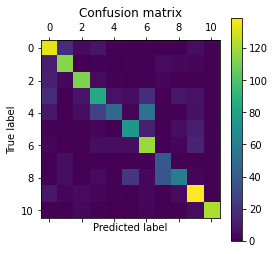

In [25]:
loaded_docs_embs_ft = load_fasttext_embedding()
x, y = create_x_y_classification(loaded_docs_embs_ft, news_df)
x_train, x_test, y_train, y_test = split_data_train_test(x, y)
clf_model = fit_naive_bayes(x_train, y_train)
save_naive_bayes(clf_model)
clf_model_loaded = load_naive_bayes()
y_pred = predict_naive_bayes(clf_model_loaded, x_test)
visualize_naive_bayes_csv(x_test, y_test, y_pred, target_category)
evaluate_naive_bayes(y_test, y_pred)